# Accuracy plots

This document contains the neccesary code to produce centroid localization prediction accuracy plots using the Hungarian method.

## Load data

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader

# Create a custom dataset class to make it compatible with the DataLoader
class CustomDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

# C dataset
dataset = torch.load('data/dataset_C.pt')

train_dataset_C = dataset['train']
test_dataset_C = dataset['test']
train_dataloader_C = DataLoader(train_dataset_C, batch_size=8, shuffle=True)
test_dataloader_C = DataLoader(test_dataset_C, batch_size=8, shuffle=False)

# CE dataset
dataset = torch.load('data/dataset_CE.pt')

train_dataset_CE = dataset['train']
test_dataset_CE = dataset['test']
train_dataloader_CE = DataLoader(train_dataset_CE, batch_size=8, shuffle=True)
test_dataloader_CE = DataLoader(test_dataset_CE, batch_size=8, shuffle=False)

# CESq dataset
dataset = torch.load('data/dataset_CESq.pt')

train_dataset_CESq = dataset['train']
test_dataset_CESq = dataset['test']
train_dataloader_CESq = DataLoader(train_dataset_CESq, batch_size=8, shuffle=True)
test_dataloader_CESq = DataLoader(test_dataset_CESq, batch_size=8, shuffle=False)

In [2]:
images_C, _, positions_C = zip(*test_dataset_C)
images_C = torch.stack(images_C)
positions_C = torch.stack(positions_C)

images_CE, _, _, positions_CE_C, positions_CE_E = zip(*test_dataset_CE)
images_CE = torch.stack(images_CE)
positions_CE_C = torch.stack(positions_CE_C)
positions_CE_E = torch.stack(positions_CE_E)
positions_CE = torch.cat((positions_CE_C, positions_CE_E), dim=0)

images_CESq, _,_, _, positions_CESq_C, positions_CESq_E, positions_CESq_Sq = zip(*test_dataset_CESq)
images_CESq = torch.stack(images_CESq)
positions_CESq_C = torch.stack(positions_CESq_C)
positions_CESq_E = torch.stack(positions_CESq_E)
positions_CESq_Sq = torch.stack(positions_CESq_Sq)
positions_CESq = torch.cat((positions_CESq_C, positions_CESq_E, positions_CESq_Sq), dim=0)

## Architecture (LodeSTAR 2.8)

In [3]:
import sys
import os

# Add the parent directory to the Python path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from LodeSTAR2_8_loss import LodeSTAR
from functions.hungarian_algorithm import compute_matching

## One class comparison

In [4]:
import deeplay as dl

lodestar = dl.LodeSTAR(optimizer=dl.Adam(lr=1e-4)).build()
lodestar.load_state_dict(torch.load('models/lodestar.pth'))

lodestar2_C = LodeSTAR(optimizer=dl.Adam(lr=1e-4), num_classes=1).build()
lodestar2_C.load_state_dict(torch.load('models/lodestar2_C.pth'))

lodestar2_CE = LodeSTAR(optimizer=dl.Adam(lr=1e-4), num_classes=2).build()
lodestar2_CE.load_state_dict(torch.load('models/lodestar2_CE.pth'))

lodestar2_CESq = LodeSTAR(optimizer=dl.Adam(lr=1e-4), num_classes=3).build()
lodestar2_CESq.load_state_dict(torch.load('models/lodestar2_CESq.pth'))

lodestar.eval()
result1_C = lodestar.detect(images_C)
lodestar2_C.eval()
result2_C = lodestar2_C.detect(images_C)
lodestar2_CE.eval()
result2_CE = lodestar2_CE.detect(images_CE)
lodestar2_CESq.eval()
result2_CESq = lodestar2_CESq.detect(images_CESq)

In [5]:
import numpy as np

# lc (np ground truth centroids)
positions_C = positions_C.numpy()
positions_CE = positions_CE.numpy()
positions_CESq = positions_CESq.numpy()

# Hungariam algorithm for LodeSTAR
# pc (np predicted centroids)
result_C_np = np.vstack(result1_C)

true_positives1, pairs_dist1, false_negatives1, false_positives1, jaccard_index1 = compute_matching(positions_C, result_C_np, distance_threshold=5)

print(f"True Positives1: {true_positives1}")
print(f"False Negatives1: {false_negatives1}")
print(f"False Positives1: {false_positives1}")
print(f"Jaccard Index1: {jaccard_index1}")

# Hungariam algorithm for LodeSTAR2 - C
# pc (np predicted centroids)
result_C_np = np.vstack(result2_C)

true_positives2, pairs_dist2, false_negatives2, false_positives2, jaccard_index2 = compute_matching(positions_C, result_C_np, distance_threshold=5)

print(f"True Positives2: {true_positives2}")
print(f"False Negatives2: {false_negatives2}")
print(f"False Positives2: {false_positives2}")
print(f"Jaccard Index2: {jaccard_index2}")

# Hungariam algorithm for LodeSTAR2 - CE
# pc (np predicted centroids)
result_CE_np = np.vstack(result2_CE)

true_positives3, pairs_dist3, false_negatives3, false_positives3, jaccard_index3 = compute_matching(positions_CE, result_CE_np, distance_threshold=5)

print(f"True Positives3: {true_positives3}")
print(f"False Negatives3: {false_negatives3}")
print(f"False Positives3: {false_positives3}")
print(f"Jaccard Index3: {jaccard_index3}")

# Hungariam algorithm for LodeSTAR2 - CESq
# pc (np predicted centroids)
result_CESq_np = np.vstack(result2_CESq)

true_positives4, pairs_dist4, false_negatives4, false_positives4, jaccard_index4 = compute_matching(positions_CESq, result_CESq_np, distance_threshold=5)

print(f"True Positives4: {true_positives4}")
print(f"False Negatives4: {false_negatives4}")
print(f"False Positives4: {false_positives4}")
print(f"Jaccard Index4: {jaccard_index4}")

True Positives1: 100
False Negatives1: 0
False Positives1: 0
Jaccard Index1: 1.0
True Positives2: 100
False Negatives2: 0
False Positives2: 31
Jaccard Index2: 0.7633587786259542
True Positives3: 200
False Negatives3: 0
False Positives3: 31
Jaccard Index3: 0.8658008658008658
True Positives4: 300
False Negatives4: 0
False Positives4: 79
Jaccard Index4: 0.7915567282321899


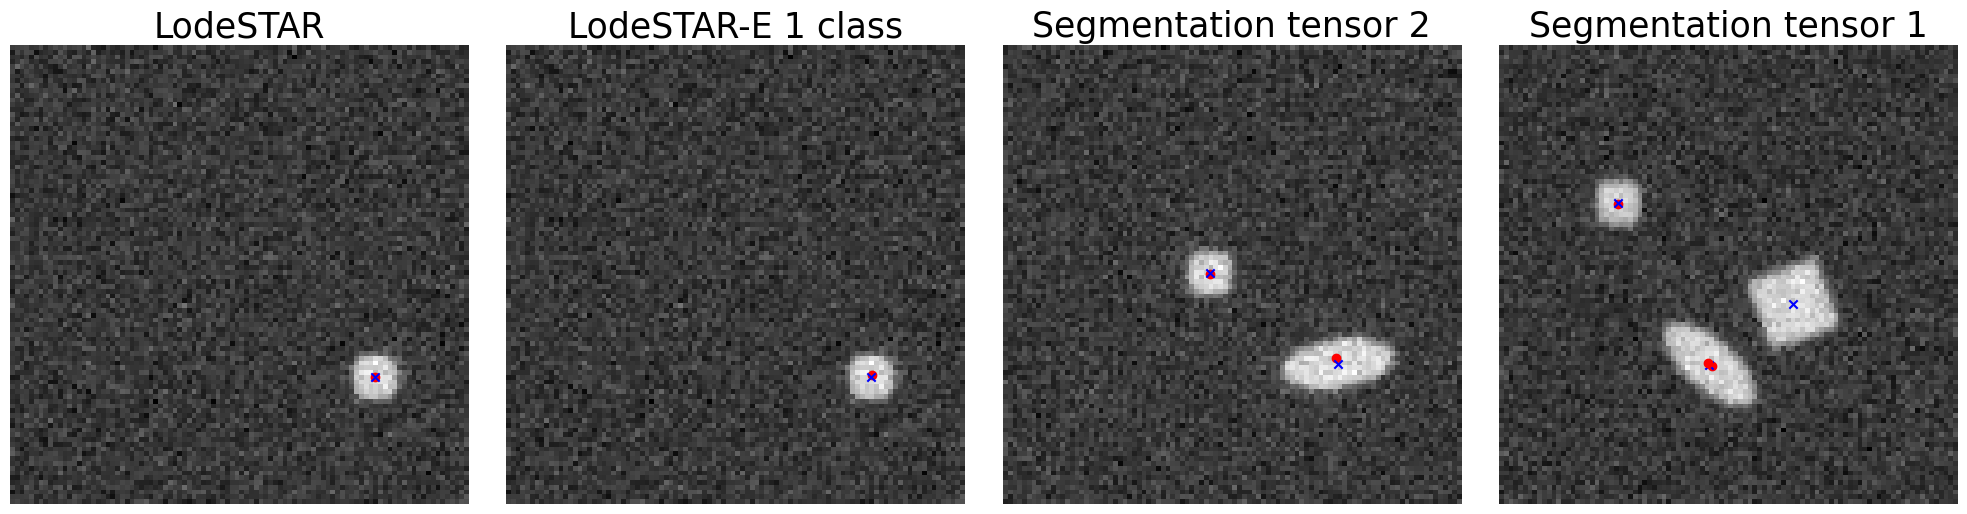

In [11]:
import matplotlib.pyplot as plt

x = 5

fig, axes = plt.subplots(1, 4, figsize=(20, 5))
# LodeSTAR
axes[0].imshow(images_C[x,...].squeeze(), cmap="gray", origin="lower")
axes[0].scatter(result1_C[x][0][1], result1_C[x][0][0], c="r")
axes[0].scatter(positions_C[x][1], positions_C[x][0], c="b", marker='x')
axes[0].set_title('LodeSTAR', fontsize=25)
axes[0].axis('off')

# LodeSTAR2 - C
axes[1].imshow(images_C[x,...].squeeze(), cmap="gray", origin="lower")
axes[1].scatter(result2_C[x][0][1], result2_C[x][0][0], c="r")
axes[1].scatter(positions_C[x][1], positions_C[x][0], c="b", marker='x')
axes[1].set_title('LodeSTAR-E 1 class', fontsize=25)
axes[1].axis('off')

# LodeSTAR2 - CE
axes[2].imshow(images_CE[x,...].squeeze(), cmap="gray", origin="lower")
axes[2].scatter(result2_CE[x][0][1], result2_CE[x][0][0], c="r")
axes[2].scatter(positions_CE[x][1], positions_CE[x][0], c="b", marker='x')
axes[2].scatter(result2_CE[x][1][1], result2_CE[x][1][0], c="r")
axes[2].scatter(positions_CE_E[x][1], positions_CE_E[x][0], c="b", marker='x')
axes[2].set_title('LodeSTAR-E 2 classes', fontsize=25)
axes[2].axis('off')

# LodeSTAR2 - CESq
axes[3].imshow(images_CESq[x,...].squeeze(), cmap="gray", origin="lower")
axes[3].scatter(result2_CESq[x][0][1], result2_CESq[x][0][0], c="r")
axes[3].scatter(positions_CESq[x][1], positions_CESq[x][0], c="b", marker='x')
axes[3].scatter(result2_CESq[x][1][1], result2_CESq[x][1][0], c="r")
axes[3].scatter(positions_CESq_E[x][1], positions_CESq_E[x][0], c="b", marker='x')
axes[3].scatter(result2_CESq[x][2][1], result2_CESq[x][2][0], c="r")
axes[3].scatter(positions_CESq_Sq[x][1], positions_CESq_Sq[x][0], c="b", marker='x')
axes[3].set_title('LodeSTAR-E 3 classes', fontsize=25)
axes[3].axis('off')

plt.tight_layout()
plt.show()


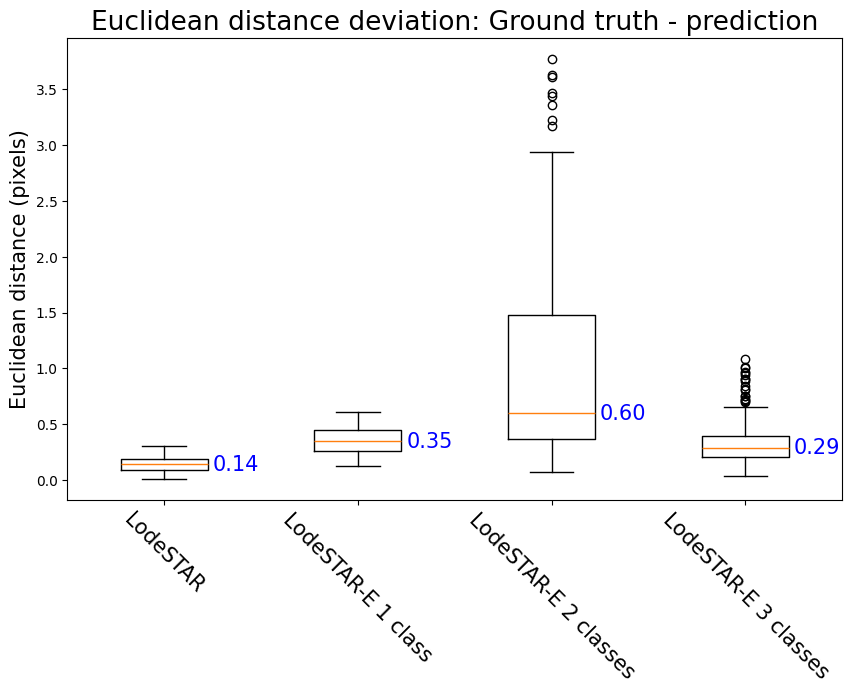

In [8]:
median1 = np.median(pairs_dist1)
median2 = np.median(pairs_dist2)
median3 = np.median(pairs_dist3)
median4 = np.median(pairs_dist4)

data_to_plot = [pairs_dist1, pairs_dist2, pairs_dist3, pairs_dist4]

labels = ['LodeSTAR', 'LodeSTAR-E 1 class', 'LodeSTAR-E 2 classes', 'LodeSTAR-E 3 classes']

plt.figure(figsize=(10, 6))
boxplot = plt.boxplot(data_to_plot, labels=labels)
for i, mean in enumerate([median1, median2, median3, median4], start=1):
    plt.annotate(f'{mean:.2f}', xy=(i, mean), xytext=(i + 0.25, mean),
                 va='center', ha='left', fontsize=15, color='blue')
plt.title('Euclidean distance deviation: Ground truth - prediction', fontsize=19)
plt.ylabel('Euclidean distance (pixels)', fontsize=15)
plt.xticks(rotation=-45, fontsize=15)
plt.show()